In [1]:
# User may need to pip install SHAP to run file.
# pip install shap

In [2]:
import pandas as pd
import numpy as np
import shap
shap.initjs()
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, roc_auc_score, accuracy_score


In [3]:
# Read in data sets - first set has denver data with outliers removed and encoded. Next set has ID and classification groupings.
df = pd.read_csv('1_denver_no_outliers_encoded_not_scaled.csv')

segments = pd.read_csv("1_pca_kmeans_seg.csv")

In [4]:
# segments.head()

rows = len(segments)
rows2 = len(df)
print({rows})
print({rows2})

{3565}
{3565}


In [5]:
# Check for nulls in rf_data and encoded_id_df so no issues when join.
null_counts = df.isnull().sum().sort_values(ascending=False)
null_counts_over0 = null_counts[null_counts > 0]
null_counts2 = segments.isnull().sum().sort_values(ascending=False)
null_counts2_over0 = null_counts2[null_counts2 > 0]
print(null_counts_over0)
print(null_counts2_over0)

Series([], dtype: int64)
Series([], dtype: int64)


Below cell has two options:
1. merge dataset with PCA Kmeans cluster assignments
2. Do not merge dataset with PCA Kmeans cluster assignments

We tried both and found that when we included the PCA Kmeans clusters with the rest of the data, the prediction outcome relied most heavily on the cluster assignment. Our concern was that this
was basing regression predictions on clustering predictions. We found that we were still able to achieve sufficient model metric scores without the PCA Kmeans clusters included, so we decided to 
leave them out of the regression model.

In [6]:
# merge encoded dataframe with rest of data by id

# rf_regress_df = pd.merge(segments, df, on='id', how='inner')
# rf_regress_df.head()

# create code to name rf_regress_df WITHOUT PCA segment data included.

rf_regress_df = df
rf_regress_df.head()

,id,accommodates,bedrooms,beds,price,availability_30,availability_60,availability_90,availability_365,number_of_reviews,...,bath_number,prop_type_reduced_Entire condo,prop_type_reduced_Entire guest suite,prop_type_reduced_Entire guesthouse,prop_type_reduced_Entire home,prop_type_reduced_Entire rental unit,prop_type_reduced_Entire townhouse,prop_type_reduced_Other,has_availability_f,has_availability_t
0,360,3,2.0,2.0,90.0,4,27,57,147,179,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,364,3,1.0,1.0,179.0,23,53,83,358,87,...,1.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,31503,2,1.0,1.0,103.0,12,42,72,347,159,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,39405,2,1.0,1.0,136.0,6,7,32,114,667,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,154999,2,1.0,1.0,162.0,0,0,0,139,11,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [7]:
# Check for nulls in rf_data and encoded_id_df so no issues when join.
rf_nulls = rf_regress_df.isnull().sum().sort_values(ascending=False)
rf_nulls_over0 = rf_nulls[rf_nulls > 0]

print(rf_nulls_over0)

Series([], dtype: int64)


In [8]:
# Set id as index so can retain id through the split and prediction process
rf_regress_df= rf_regress_df.set_index('id')

In [9]:
# check row count of merged dataframe

final_rows = len(rf_regress_df)
print(f"rf rows {final_rows}")

rf rows 3565


Below section builds the random forest regressor model.

We need to use regression because the 2 data points we plan to predict are continuous data (not classification data).

The predictions will be for:
- review_scores_rating
- availability_30

The availability data (30, 60, 90, 365 day availability) has multicollinearity in that data is duplicated across 
these columns.  Because of this, when predicting the 30 day availability, we remove all other availability columns.

In [10]:
##### random forest no need to encode or scale

In [11]:
rf_regress_df.columns

Index(['accommodates', 'bedrooms', 'beds', 'price', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'bath_number', 'prop_type_reduced_Entire condo',
       'prop_type_reduced_Entire guest suite',
       'prop_type_reduced_Entire guesthouse', 'prop_type_reduced_Entire home',
       'prop_type_reduced_Entire rental unit',
       'prop_type_reduced_Entire townhouse', 'prop_type_reduced_Other',
       'has_availability_f', 'has_availability_t'],
      dtype='object')

In [13]:
# create x and y (drop 30, 60, 90, 365 day booking or review scores rating)

X_avail = rf_regress_df.copy()
X_avail.drop(['availability_30', 
              'availability_60',
              'availability_90',
              'availability_365'
              ], axis=1, inplace=True)
X_rating = rf_regress_df.copy()
X_rating.drop(['review_scores_rating', 'prop_type_reduced_Entire condo',
        'prop_type_reduced_Entire guest suite',
        'prop_type_reduced_Entire guesthouse', 'prop_type_reduced_Entire home',
        'prop_type_reduced_Entire rental unit',
        'prop_type_reduced_Entire townhouse', 'prop_type_reduced_Other',
        'has_availability_f', 'has_availability_t'], axis=1, inplace=True)
X_price = rf_regress_df.copy()
X_price.drop('price', axis=1, inplace=True)

y_avail = rf_regress_df['availability_30']
y_rating = rf_regress_df['review_scores_rating']
y_price = rf_regress_df['price']

In [14]:
# get y sets into array format
y_avail.ravel()
y_rating.ravel()
y_price.ravel()

array([ 90., 179., 103., ..., 128.,  50.,  86.])

In [15]:
# train_test_split on x and y for availability, ratings, price data sets
X_avail_train, X_avail_test, y_avail_train, y_avail_test = train_test_split(X_avail, y_avail, random_state=1)

X_rating_train, X_rating_test, y_rating_train, y_rating_test = train_test_split(X_rating, y_rating, random_state=1)

X_price_train, X_price_test, y_price_train, y_price_test = train_test_split(X_price, y_price, random_state=1)


In [16]:
# create random forest regression models for availability and bookings
rf_regress_avail_model = RandomForestRegressor(random_state=1)

rf_regress_avail_model = rf_regress_avail_model.fit(X_avail_train, y_avail_train)

# During model optimization, tested wide variety of n_estimators number to arrive at most efficient/most accurate
rf_regress_rating_model = RandomForestRegressor(n_estimators=100, random_state=1)

rf_regress_rating_model = rf_regress_rating_model.fit(X_rating_train, y_rating_train)

rf_regress_price_model = RandomForestRegressor(n_estimators=100, random_state=1)

rf_regress_price_model = rf_regress_price_model.fit(X_price_train, y_price_train)

In [17]:
# make predictions

y_pred_regress_avail = rf_regress_avail_model.predict(X_avail_test)
y_pred_regress_rating = rf_regress_rating_model.predict(X_rating_test)
y_pred_regress_price = rf_regress_price_model.predict(X_price_test)

In [18]:
# Calculate Mean Absolute Error
mae_avail = mean_absolute_error(y_avail_test, y_pred_regress_avail)
mae_rating = mean_absolute_error(y_rating_test, y_pred_regress_rating)
mae_price = mean_absolute_error(y_price_test, y_pred_regress_price)
print(f"Mean Absolute Error availability: {mae_avail}")
print(f"Mean Absolute Error rating: {mae_rating}")
print(f"Mean Absolute Error price: {mae_price}")
print("------------------------------------------")

# Calculate Mean Squared Error
mse_avail = mean_squared_error(y_avail_test, y_pred_regress_avail)
mse_rating = mean_squared_error(y_rating_test, y_pred_regress_rating)
mse_price = mean_squared_error(y_price_test, y_pred_regress_price)
print(f"Mean Squared Error availiability: {mse_avail}")
print(f"Mean Squared Error rating: {mse_rating}")
print(f"Mean Squared Error price: {mse_price}")
print("------------------------------------------")

# Calculate Root Mean Squared Error
rmse_avail = np.sqrt(mse_avail)
rmse_rating = np.sqrt(mse_rating)
rmse_price = np.sqrt(mse_price)
print(f"Root Mean Squared Error availability: {rmse_avail}")
print(f"Root Mean Squared Error rating: {rmse_rating}")
print(f"Root Mean Squared Error price: {rmse_price}")
print("------------------------------------------")

# Calculate R-squared
r2_avail = r2_score(y_avail_test, y_pred_regress_avail)
r2_rating = r2_score(y_rating_test, y_pred_regress_rating)
r2_price = r2_score(y_price_test, y_pred_regress_price)
print(f"R-squared availability: {r2_avail}")
print(f"R-squared rating: {r2_rating}")
print(f"R-squared price: {r2_price}")

Mean Absolute Error availability: 7.325830023489216
Mean Absolute Error rating: 0.06261995515695053
Mean Absolute Error price: 42.76865705744181
------------------------------------------
Mean Squared Error availiability: 81.18764389810154
Mean Squared Error rating: 0.01872680123318386
Mean Squared Error price: 3228.4074868279035
------------------------------------------
Root Mean Squared Error availability: 9.010418630568811
Root Mean Squared Error rating: 0.13684590323858387
Root Mean Squared Error price: 56.819076786127944
------------------------------------------
R-squared availability: 0.022508076886844308
R-squared rating: 0.8015567419239378
R-squared price: 0.4753523324404648


We are trying to predict continuous data for both the 30 day bookings and the review ratings.  Therefore we have to use a regression model (not a classification model). And our metrics to measure accuracy need to be suited for regression, not classification.

Below is further info on the 4 regression metrics:

mean absolute error: 
- lower outcome is better
- range 0 to infinity
- MAE provides the average absolute difference between the predicted values and the actual values. A MAE of 0 means perfect predictions with no errors. The "goodness" of MAE depends on the scale of the target variable; a small MAE is more desirable, indicating that the model's predictions are close to the actual values.

mean squared error:
- lower outcome is better
- range 0 to infinity
- MSE is similar to MAE but squares the differences before averaging them, which penalizes larger errors more severely. A MSE of 0 indicates perfect predictions. Like MAE, whether an MSE is considered good depends on the scale of the data. Lower MSE values indicate better model performance.

root mean squared error:
- lower outcome is better
- range 0 to infinity
- RMSE is the square root of MSE, bringing the error metric back to the scale of the target variable. This makes it more interpretable than MSE. A lower RMSE indicates better model performance, and an RMSE of 0 indicates perfect predictions.

R-squared:
- higher outcome is better
- range neg. infinity to 1
- R-squared measures the proportion of the variance in the dependent variable that is predictable from the independent variables. A value of 1 indicates that the model perfectly predicts the target variable, while a value of 0 indicates that the model does no better than simply predicting the mean of the target variable. Negative R-squared values can occur when the chosen model fits worse than a horizontal line. Higher values indicate better fit, but the "goodness" of an R-squared value also depends on the context and complexity of the model.

In [19]:
# Get the feature importance array for availability and rating

feature_importances_avail = rf_regress_avail_model.feature_importances_
feature_importances_rating = rf_regress_rating_model.feature_importances_


In [20]:
# match feature importance with feature names and sort

# importances_sorted_avail = sorted(zip(feature_importances_avail, X_avail.columns), reverse=True)
# importances_sorted_rating = sorted(zip(feature_importances_rating, X_rating.columns), reverse=True)
# importances_sorted_avail


In [21]:
# Create sorted dataframe of availability features and importance scores
feature_names_avail = X_avail_train.columns
importances_avail_df = pd.DataFrame({'Feature': feature_names_avail, 'Importance': feature_importances_avail })
importances_avail_df_sorted = importances_avail_df.sort_values(by='Importance', ascending=False)
importances_avail_df_sorted.head(5)

,Feature,Importance
3,price,0.163971
5,number_of_reviews_ltm,0.091983
4,number_of_reviews,0.088296
13,review_scores_value,0.072222
9,review_scores_cleanliness,0.064825


In [22]:
# Create sorted dataframe of rating features and importance scores
feature_names_rating = X_rating_train.columns
importances_rating_df = pd.DataFrame({'Feature': feature_names_rating, 'Importance': feature_importances_rating })
importances_rating_df_sorted = importances_rating_df.sort_values(by='Importance', ascending=False)
importances_rating_df_sorted.head(5)

,Feature,Importance
16,review_scores_value,0.373706
11,review_scores_accuracy,0.333388
14,review_scores_communication,0.127103
12,review_scores_cleanliness,0.033139
15,review_scores_location,0.024485


In [23]:
sum_top_values = importances_rating_df_sorted['Importance'].head(8).sum()
print({sum_top_values})

{0.9481876879721074}


In [24]:
# plot top feature importances for availability

# N = 8
# top_features_avail = importances_avail_df_sorted.head(N)

# plt.figure(figsize=(18, 8))
# plt.bar(top_features_avail['Feature'], top_features_avail['Importance'])
# plt.xlabel('Feature', fontsize=12)
# plt.ylabel('Importance', fontsize=12)
# plt.title('Top Feature Importances Random Forest Regression Availability')
# plt.xticks(fontsize=12, rotation=45)  # Rotate x-ticks for better readability 
# plt.yticks(fontsize=12)

# plt.show()

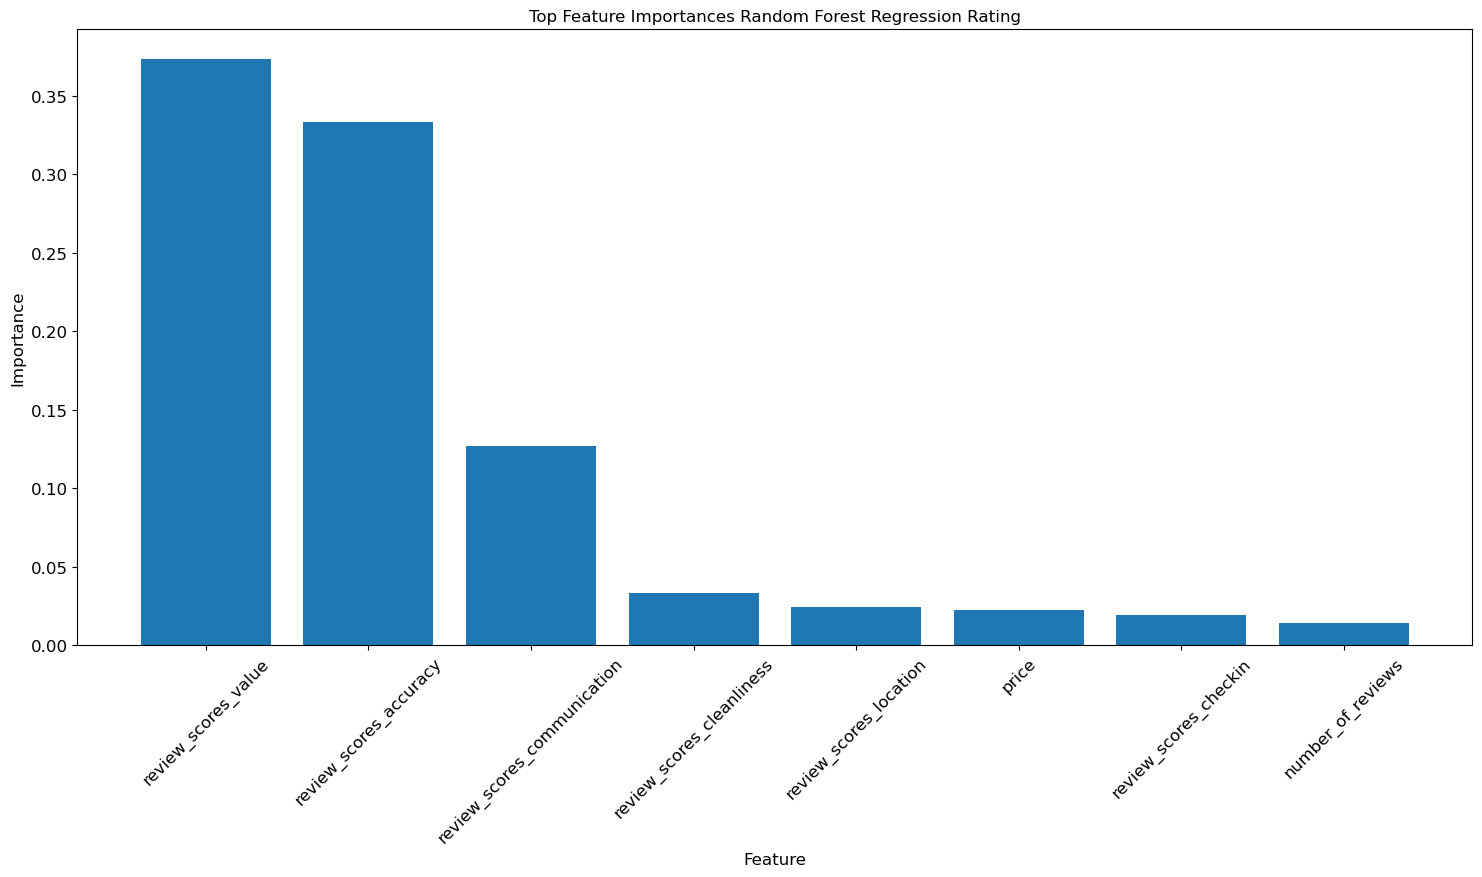

In [25]:
# plot top feature importances for rating

N = 8
top_features_rating = importances_rating_df_sorted.head(N)

plt.figure(figsize=(18, 8))
plt.bar(top_features_rating['Feature'], top_features_rating['Importance'])
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.title('Top Feature Importances Random Forest Regression Rating')
plt.xticks(fontsize=12, rotation=45)  # Rotate x-ticks for better readability 
plt.yticks(fontsize=12)

plt.show()

In [26]:
# Set up a SHAP (SHapely Additive exPlanations) explainer to explain how the predictions were made

explainer = shap.Explainer(rf_regress_rating_model)
shap_values = explainer.shap_values(X_rating_test)

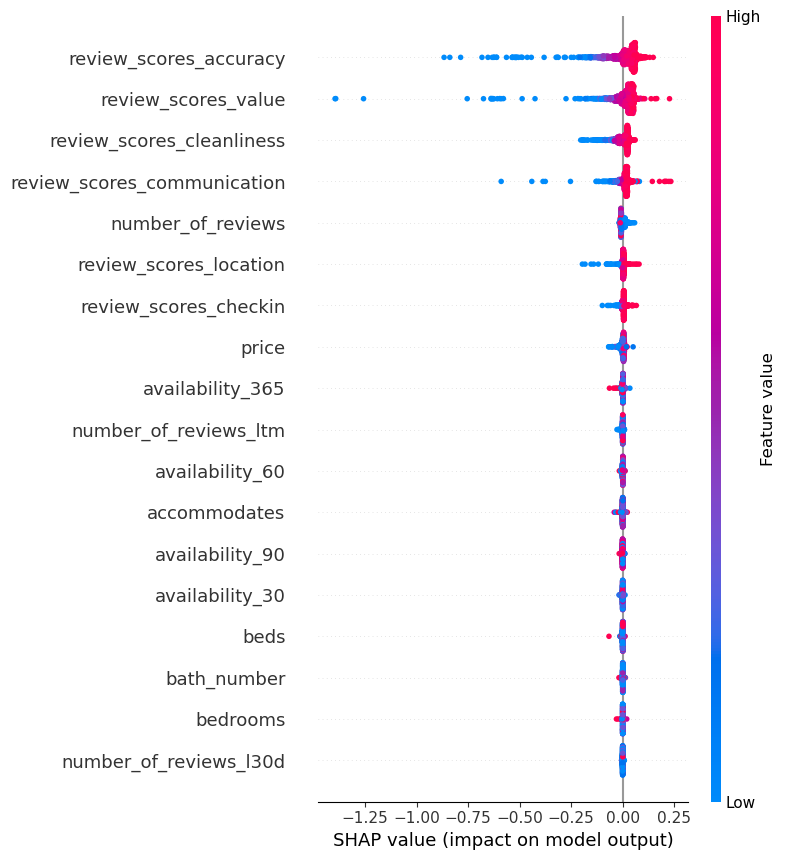

In [27]:
# plot the SHAP summary

shap.summary_plot(shap_values, X_rating_test)